In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Liver from 10x.
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Liver data, 10X 3'v2 assay in .h5ad format was used for further analysis. Decision made to cover absence of Kuppfer cells female young in the Smart-seq2 database.

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + '/TM_liver_10x.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# No need to remove EEF1A1 and RAC1 genes, in 10X approach they appeared

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 18/18 [00:00<00:00, 11772.57it/s]


In [5]:
barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595


## CMA net score/cell type (fold over whole tissue)

In [6]:
# Checking n of mice 
list(barcode['mouse.id'].unique())

['18-F-51',
 '21-F-54',
 '24-M-58',
 '24-M-59',
 '30-M-3',
 '30-M-4',
 '30-M-5',
 '1-M-62',
 '1-M-63',
 '3-M-8/9',
 '3-F-56',
 '3-F-57']

**Mice n for Liver**
    - Young females: 2
    - Young males: 3
    - Old females: 2
    - Old males: 5

In [6]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '1m':        
        barcode.loc[j, 'new_age'] = '1-3m'
    
    elif barcode.loc[j, 'age'] == '3m':                
        barcode.loc[j, 'new_age'] = '1-3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-30m'

    elif barcode.loc[j, 'age'] == '21m': 
        barcode.loc[j, 'new_age'] = '18-30m'
    
    elif barcode.loc[j, 'age'] == '24m':                
        barcode.loc[j, 'new_age'] = '18-30m'

    elif barcode.loc[j, 'age'] == '30m':                
        barcode.loc[j, 'new_age'] = '18-30m'

barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m


In [7]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '1-3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,normal,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513


In [9]:
print(list(barcode.cell_type.unique()))

['hepatocyte', 'endothelial cell of hepatic sinusoid', 'Kupffer cell', 'hepatic stellate cell', 'natural killer cell', 'plasmacytoid dendritic cell', 'B cell', 'myeloid leukocyte', 'duct epithelial cell']


In [8]:
cells = ['hepatocyte', 'Kupffer cell'] 

## CMA net score/cell type & sex (fold over each cell type young)

In [9]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '1-3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 9/9 [00:00<00:00, 20.59it/s]


,age,cell,free_annotation,method,donor_id,n_genes,subtissue,n_counts,louvain,leiden,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,Mus musculus,female,liver,na,18 month-old stage,ghq^6>2Cj>,-0.802075,18-30m,-0.784992,-0.825102
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,Mus musculus,female,liver,na,18 month-old stage,0AZ4zIEVgc,0.022095,18-30m,0.039177,-0.000933
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,Mus musculus,female,liver,na,18 month-old stage,W7+}-!fosq,-0.367614,18-30m,-0.350531,-0.390641
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568359,1,1,...,Mus musculus,female,liver,na,18 month-old stage,5zbU*lX{gq,-0.307166,18-30m,-0.290083,-0.330193
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,Mus musculus,female,liver,na,18 month-old stage,wvv9<D^@o-,-0.265595,18-30m,-0.248513,-0.288623


### Graphs

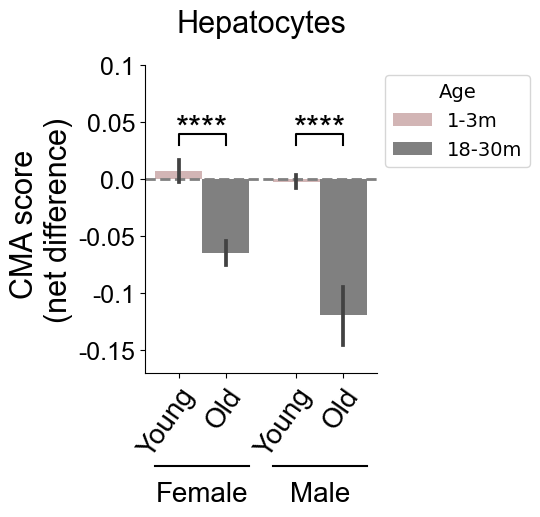

In [10]:
# Figure Hepatocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.17, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, .2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Hepat10x_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

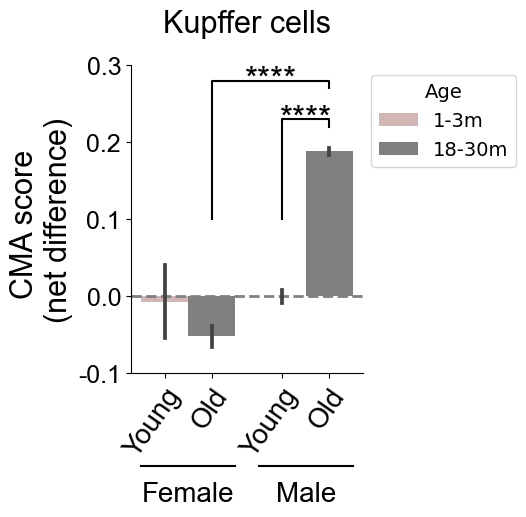

In [11]:
# Figure Kupffer cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.30)
ax.set_yticks([-0.10, 0.00, 0.10, 0.20, 0.30])
ax.set_yticklabels([-0.10, 0.00, 0.10, 0.20, 0.30], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y1, y2, h, col = 0.1, 0.22, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y1, y2, h, col = 0.1, 0.27, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig(output_dir + '/Kupf10x_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [12]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Liv10x_Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
        
    return(df_raw)

In [13]:
raw(tipos = cells, edad=['1-3m', '18-30m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,hepatocyte,1-3m,female,536,0.006880,0.009703
1,hepatocyte,1-3m,male,1768,-0.002086,0.005158
2,hepatocyte,18-30m,female,517,-0.064934,0.010560
3,hepatocyte,18-30m,male,108,-0.119131,0.026078
4,Kupffer cell,1-3m,female,13,-0.006926,0.049874
5,Kupffer cell,1-3m,male,614,0.000147,0.008274
6,Kupffer cell,18-30m,female,246,-0.051975,0.012770
7,Kupffer cell,18-30m,male,1673,0.187961,0.004537


## CMA network heatmaps by cell type & sex

In [14]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'EEF1A1', 'PHLPP1', 'RAC1', 'NFATC1', 'NCOR1', 'NFE2L2', 
          'RAB11A', 'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [15]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((18, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "1-3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-30m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "1-3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-30m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Liv10x_Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:4]+'_heat', index=True)
        
    # Plotting with all proteins
    if cellpop == cells[1]:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(18), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(17.5, -0.5)

        plt.xticks(np.arange(4), ['1-3m', '18-30m', '1-3m', '18-30m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.6, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.35,-1.35],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.6, 5.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.35,-1.35],[4.75, 12.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.6, 12), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.35,-1.35],[12.75, 17.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.05, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.7, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.6, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else: # plotting without GFAP
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(17), nogfap, fontsize=16, **hfont)

        plt.ylim(16.5, -0.5)

        plt.xticks(np.arange(4), ['1-3m', '18-30m', '1-3m', '18-30m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.05)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.6, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.35,-1.35],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.6, 5.1), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.35,-1.35],[4.75, 11.15], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.6, 11.3), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.35,-1.35],[11.75, 16.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.05, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.7, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.6, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig(output_dir + '/{}_heat.png'.format(cellpop[:4]),bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 18/18 [00:00<00:00, 18.11it/s]


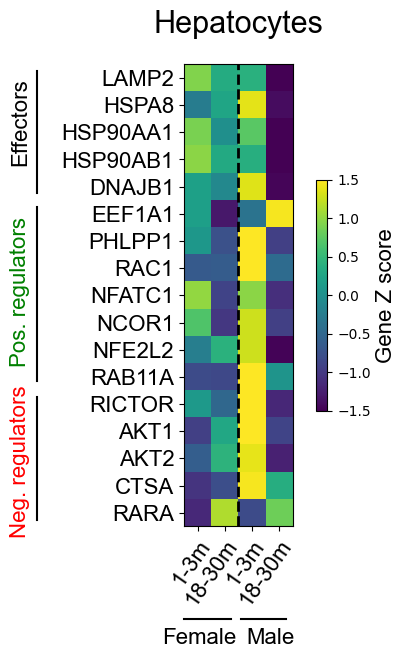

100%|██████████| 18/18 [00:01<00:00, 17.75it/s]


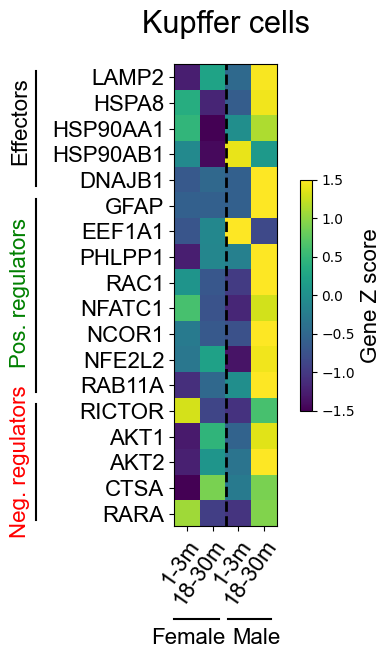

In [16]:
for i in cells:
    sex_heatmaps(cellpop=i)